# Analiza Koncentracije PM2.5 Čestica u Šangaju
### Prepoznavanje Oblika - Domaći
### Đorđe Stanković, IN13-2018

In [67]:
# Neophodni Python paketi
# pip install numpy matplotlib pandas seaborn scikit-learn

In [111]:
# Ucitavanje biblioteka i funkcija
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
from scipy.stats import norm
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, ConfusionMatrixDisplay
from sklearn import datasets
from sklearn.neighbors import KNeighborsClassifier

## Pregled Baze Podataka

• No: redni broj vrste\
• year: godina\
• month: mesec\
• day: dan u mesecu\
• hour: sat u danu\
• season: godišnje doba\
• PM: koncentracija PM2.5 čestica na nekoliko lokacija (ug/m3)\
• DEWP: temperatura rose/kondenzacije (stepeni Celzijusa)\
• HUMI: vlažnost vazduha (%)\
• PRES: vazdušni pritisak (hPa)\
• TEMP: temperatura (stepeni Celzijusa)\
• cbwd: pravac vetra (N-sever, S-jug, E-istok, W-zapad, cv-calm/variable)\
• Iws: brzina vetra (m/s)\
• precipitation: padavine na sat (mm)\
• Iprec: ukupne padavine (mm), odnosno kumulativna suma padavina po satima dok ne prestanu padavine.

In [69]:
df = pd.read_csv('ShanghaiPM20100101_20151231.csv')
df.drop(labels = ["No", "PM_Jingan", "PM_Xuhui"], axis=1, inplace=True)
# print(df.tail())
print("Baza ima", df.shape[0], "uzoraka i", df.shape[1],"obelezja.")

Baza ima 52584 uzoraka i 14 obelezja.


Baza ima 52584 uzoraka i 17 obelezja.\
Uzorak baze predstavlja casovno merenje senzora za kvalitet vazduha.\
Kategoricka obelezja su No, Year, Month, Day, Hour, Season i cbwd.\
Numericka obelezja su PM, DEWP, HUMI, PRES, TEMP, Iws, precipitation i Iprec.\
No, PM_jingan i PM_Xuhui su nepotrebna obelezja, i mozemo da ih izbacimo.

In [70]:

df.columns=["Year","Month","Day","Hour","Season","PM (ug/m3)", "Dew Temp (C)", "Humidity (%)","Pressure (hPa)","Temperature (C)","Wind Direction","Wind Speed (m/s)","Precipitation (mm)", "TotalPrec (mm)"]
df.describe().round(2).drop(["Year", "Month", "Day", "Hour", "Season"], axis=1)

,PM (ug/m3),Dew Temp (C),Humidity (%),Pressure (hPa),Temperature (C),Wind Speed (m/s),Precipitation (mm),TotalPrec (mm)
count,34039.00,52571.00,52571.00,52556.00,52571.00,52572.00,48575.00,48575.00
mean,52.91,11.30,69.55,1016.02,17.47,49.60,0.14,0.94
std,42.58,9.88,17.66,9.02,9.32,78.28,1.07,6.59
min,1.00,-21.00,11.32,990.00,-5.00,0.00,0.00,0.00
25%,26.00,3.00,57.93,1008.10,10.00,6.00,0.00,0.00
50%,41.00,12.00,72.42,1016.00,18.00,20.00,0.00,0.00
75%,67.00,20.00,83.37,1023.00,25.00,61.00,0.00,0.00
max,730.00,28.00,100.00,1040.00,41.00,1110.00,61.60,226.40


In [71]:
df.isnull().sum()

Year                      0
Month                     0
Day                       0
Hour                      0
Season                    0
PM (ug/m3)            18545
Dew Temp (C)             13
Humidity (%)             13
Pressure (hPa)           28
Temperature (C)          13
Wind Direction           12
Wind Speed (m/s)         12
Precipitation (mm)     4009
TotalPrec (mm)         4009
dtype: int64

Year, Month, Day, Hour i Season obelezja imaju ocekivane statistike i nemaju nedostajuce vrednosti.\
Obelezje PM (US) ima NaN vrednosti sve do 17443. uzorka, ali se i kasnije pojavljuju.\
Svi uzorci do 17443. (odnosno do 28.12.2011.) ce biti izbaceni pri kreiranju regresora.\
Dew Temp, Humidity, Pressure i Temperature imaju ocekivane statistike, ali imaju nedostajuce vrednosti.\
Wind Direction je kategoricko obelezje obelezeno string-ovima, i ima nedostajuce vrednosti.\
U slucaju ukljucivanja obelezja u regresiju, obelezje treba biti prebaceno u numericke vrednosti.\
Wind Speed ispada da je kumulativan, sto znaci da je maksimum od 1110 m/s ipak validna vrednost (iako su uragani zabelezeni na oko 40 m/s). Takodje, ima nedostajuce vrednosti.\
Precipitation i TotalPrec imaju ocekivane statistike (maksimum od 61.6 mm je odgovarajuci), ali imaju nedostajuce vrednosti.\
Padavine mogu da imaju NaN vrednost, ali to ne znaci da tog dana nije bilo padavina.

Uzorke do 17443. mozemo da izbacimo jer nemaju vrednosti za obelezje PM.\
Nakon ove izmene, baza ce imati 35142 uzoraka, i krece od 28.12.2011. godine.

In [72]:
# Pokreni samo jednom! PM treba da ima 1103 NaN vrednosti.
df.drop(df.iloc[0:17442].index, axis = 0, inplace = True)
print(df.isnull().sum())
df.head()
print("Baza ima", df.shape[0], "uzoraka i", df.shape[1],"obelezja.")

Year                     0
Month                    0
Day                      0
Hour                     0
Season                   0
PM (ug/m3)            1103
Dew Temp (C)             5
Humidity (%)             5
Pressure (hPa)          20
Temperature (C)          5
Wind Direction           4
Wind Speed (m/s)         4
Precipitation (mm)    2272
TotalPrec (mm)        2272
dtype: int64
Baza ima 35142 uzoraka i 14 obelezja.


NaN vrednosti za PM, Dew Temp, Humidity, Pressure, Temperature, Wind Direction, Wind Speed mozemo da popravimo.\
Sve NaN vrednosti mogu da se zamene '`ffill`' metodom, odnosno, mozemo da uzmemo vrednost od prethodnog sata jer se NaN vrednosti ne ponavljaju uzastopno.\
I Wind Speed i TotalPrec mogu da se fill-uju sa '`ffill`' jer su kumulativni, to ne pravi problem.

In [73]:
df["PM (ug/m3)"].fillna(method="ffill", inplace=True)
df["Dew Temp (C)"].fillna(method="ffill", inplace=True)
df["Humidity (%)"].fillna(method="ffill", inplace=True)
df["Pressure (hPa)"].fillna(method="ffill", inplace=True)
df["Temperature (C)"].fillna(method="ffill", inplace=True)
df["Wind Direction"].fillna(method="ffill", inplace=True)
df["Wind Speed (m/s)"].fillna(method="ffill", inplace=True)
df["Precipitation (mm)"].fillna(method="ffill", inplace=True)
df["TotalPrec (mm)"].fillna(method="ffill", inplace=True)
print(df.isnull().sum())

Year                  0
Month                 0
Day                   0
Hour                  0
Season                0
PM (ug/m3)            0
Dew Temp (C)          0
Humidity (%)          0
Pressure (hPa)        0
Temperature (C)       0
Wind Direction        0
Wind Speed (m/s)      0
Precipitation (mm)    0
TotalPrec (mm)        0
dtype: int64


Wind Direction mozemo prebaciti u numericke vrednosti. CV, odnosno Calm/Variable moze da bude obelezeno sa 0, ostali od 1 do 4.

In [74]:
df.loc[df["Wind Direction"] == "cv", "Wind Direction"] = 0
df.loc[df["Wind Direction"] == "NW", "Wind Direction"] = 1
df.loc[df["Wind Direction"] == "NE", "Wind Direction"] = 2
df.loc[df["Wind Direction"] == "SE", "Wind Direction"] = 3
df.loc[df["Wind Direction"] == "SW", "Wind Direction"] = 4
df.head()

,Year,Month,Day,Hour,Season,PM (ug/m3),Dew Temp (C),Humidity (%),Pressure (hPa),Temperature (C),Wind Direction,Wind Speed (m/s),Precipitation (mm),TotalPrec (mm)
17442,2011,12,28,18,4,36.0,4.0,62.00,1027.1,11.0,2,8.0,0.0,0.0
17443,2011,12,28,19,4,41.0,4.0,62.00,1027.1,11.0,2,9.0,0.0,0.0
17444,2011,12,28,20,4,44.0,5.0,71.07,1028.1,10.0,2,11.0,0.0,0.0
17445,2011,12,28,21,4,40.0,5.0,71.07,1028.1,10.0,2,13.0,0.0,0.0
17446,2011,12,28,22,4,25.0,6.0,76.18,1028.1,10.0,2,15.0,0.0,0.0


In [75]:
df.describe().round(2).drop(["Year", "Month", "Day", "Hour", "Season"], axis=1)

,PM (ug/m3),Dew Temp (C),Humidity (%),Pressure (hPa),Temperature (C),Wind Speed (m/s),Precipitation (mm),TotalPrec (mm)
count,35142.00,35142.00,35142.00,35142.00,35142.00,35142.00,35142.00,35142.00
mean,52.71,11.45,69.90,1015.87,17.56,49.45,0.15,1.00
std,42.34,9.67,17.80,9.03,9.18,71.64,1.06,7.31
min,1.00,-17.00,13.09,990.00,-4.00,0.00,0.00,0.00
25%,26.00,3.00,58.17,1008.00,10.00,6.00,0.00,0.00
50%,41.00,12.00,72.96,1016.00,19.00,20.00,0.00,0.00
75%,67.00,20.00,83.60,1023.00,25.00,62.00,0.00,0.00
max,730.00,28.00,100.00,1040.00,41.00,691.00,61.60,226.40


Podaci su sada uredjeni, mozemo poceti sa analizom obelezja.
## Analiza Obelezja

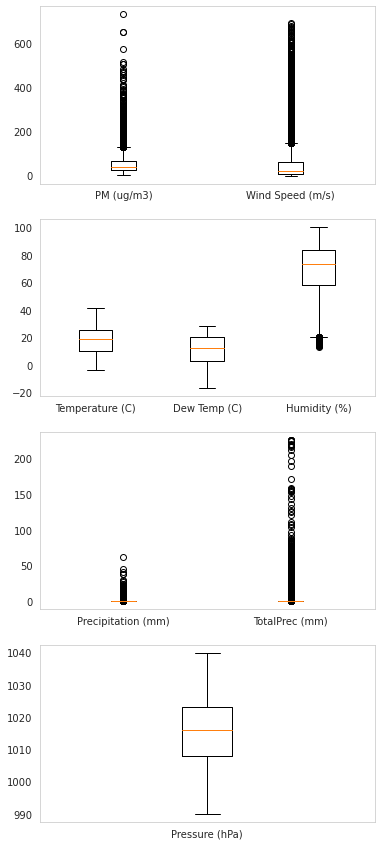

In [76]:
plt.figure(figsize=(6,15))
plt.subplot(4, 1, 1)
plt.boxplot([df["PM (ug/m3)"], df["Wind Speed (m/s)"]])
plt.xticks([1, 2], ["PM (ug/m3)", "Wind Speed (m/s)"])
plt.grid()

plt.subplot(4, 1, 2)
plt.boxplot([df["Temperature (C)"], df["Dew Temp (C)"], df["Humidity (%)"]])
plt.xticks([1, 2, 3], ["Temperature (C)", "Dew Temp (C)", "Humidity (%)"])
plt.grid()

plt.subplot(4, 1, 3)
plt.boxplot([df["Precipitation (mm)"], df["TotalPrec (mm)"]])
plt.xticks([1, 2], ["Precipitation (mm)", "TotalPrec (mm)"])
plt.grid()

plt.subplot(4, 1, 4)
plt.boxplot([df["Pressure (hPa)"]])
plt.xticks([1], ["Pressure (hPa)"])
plt.grid()

plt.savefig("boxplots.png")

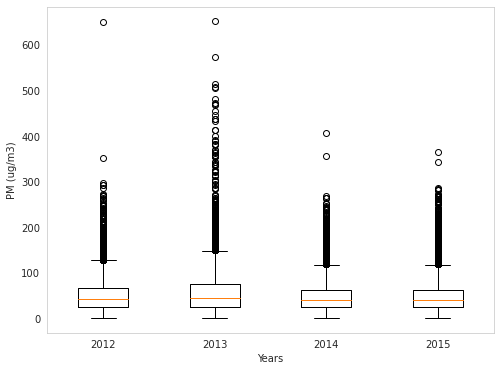

In [77]:
plt.figure(figsize=(8,6))
plt.grid()
plt.xlabel("Years")
plt.ylabel("PM (ug/m3)")
pm2012 = df.loc[df["Year"]==2012]["PM (ug/m3)"]
pm2013 = df.loc[df["Year"]==2013]["PM (ug/m3)"]
pm2014 = df.loc[df["Year"]==2014]["PM (ug/m3)"]
pm2015 = df.loc[df["Year"]==2015]["PM (ug/m3)"]
plt.boxplot([pm2012,pm2013,pm2014,pm2015])
plt.xticks([1,2,3,4], ["2012","2013","2014","2015"])
plt.savefig("pmcompare.png")

/tmp/ipykernel_56194/4285132476.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  x = df.groupby("Month").mean()


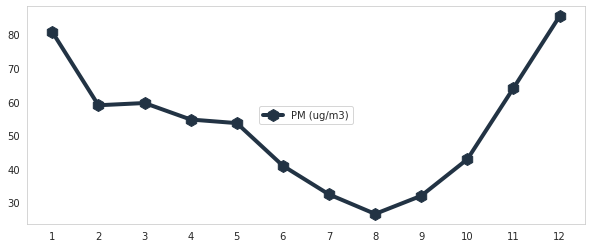

In [78]:
x = df.groupby("Month").mean()
plt.figure(figsize=(10,4))
plt.plot(x["PM (ug/m3)"], linewidth=4, color="#223344", marker="h", markersize=12, label="PM (ug/m3)")
plt.xticks(x.index)
plt.grid()
plt.legend(loc="center")
plt.savefig("monthlypm.png")

/tmp/ipykernel_56194/2808174878.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sb.distplot(df["PM (ug/m3)"], bins=40, fit=norm, color="teal")
/tmp/ipykernel_56194/2808174878.py:6: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sb.distplot(df["Humidity (%)"], bins=28, fit=norm, color="teal")
/tmp/ipykernel_56194/28081

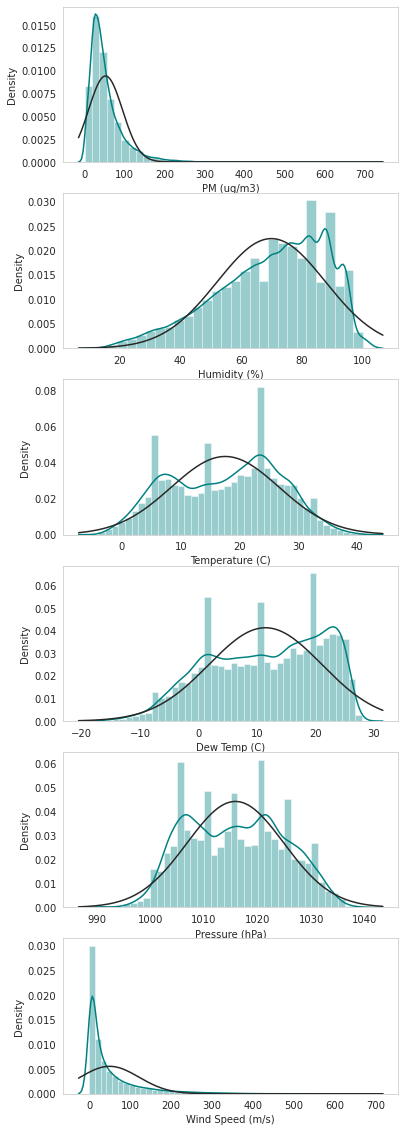

In [79]:
plt.figure(figsize = (6,20))
plt.subplot(6,1,1)
sb.distplot(df["PM (ug/m3)"], bins=40, fit=norm, color="teal")
plt.grid()
plt.subplot(6,1,2)
sb.distplot(df["Humidity (%)"], bins=28, fit=norm, color="teal")
plt.grid()
plt.subplot(6,1,3)
sb.distplot(df["Temperature (C)"], bins=40, fit=norm, color="teal")
plt.grid()
plt.subplot(6,1,4)
sb.distplot(df["Dew Temp (C)"], bins=40, fit=norm, color="teal")
plt.grid()
plt.subplot(6,1,5)
sb.distplot(df["Pressure (hPa)"], bins=40, fit=norm, color="teal")
plt.grid()
plt.subplot(6,1,6)
sb.distplot(df["Wind Speed (m/s)"], bins=50, fit=norm, color="teal")
plt.grid()
plt.savefig("raspodele.png")

/tmp/ipykernel_56194/3537163781.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corrMatrix = y.corr().round(2)


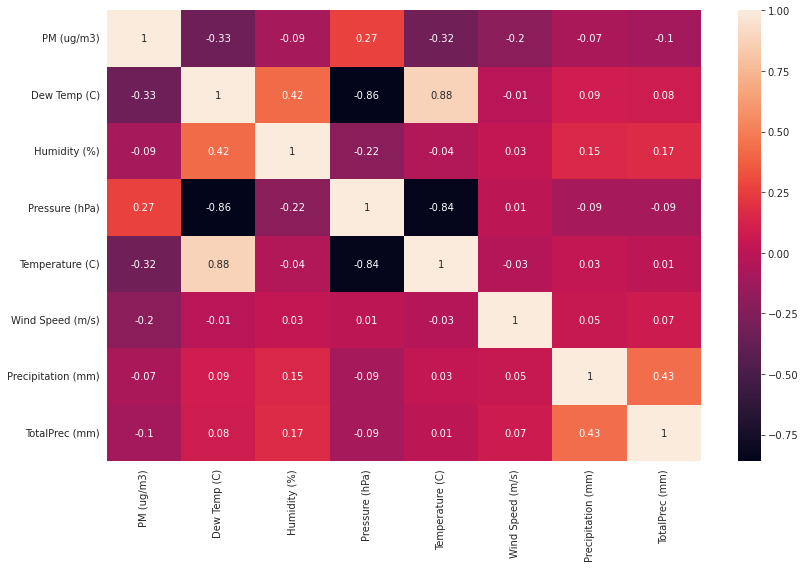

In [80]:
y = df.drop(["Year", "Month", "Day", "Hour", "Season"], axis=1)
corrMatrix = y.corr().round(2)
plt.figure(figsize=(12,8))
sb.heatmap(corrMatrix, annot=True)
plt.tight_layout()
plt.savefig("corrMatrix.png")

Count :
Wind Direction
0     1330
1     6530
2    13273
3     9984
4     4025
Name: PM (ug/m3), dtype: int64

Mean :
0 72.98345864661654
1 76.0249617151608
2 43.27687787237249
3 42.61398237179487
4 64.36546583850932


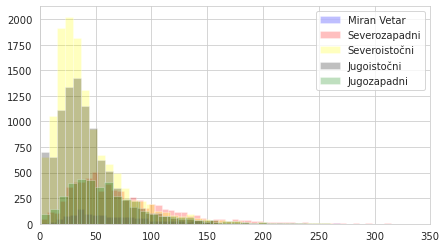

In [81]:
plt.figure(figsize=(7,4))

print("Count :")
gb = df.groupby("Wind Direction").count()
print(gb["PM (ug/m3)"])
print()

print("Mean :")
cv = df.loc[df["Wind Direction"]==0]["PM (ug/m3)"].mean()
print(0, cv)
wd1 = df.loc[df["Wind Direction"]==1]["PM (ug/m3)"].mean()
print(1, wd1)
wd2 = df.loc[df["Wind Direction"]==2]["PM (ug/m3)"].mean()
print(2, wd2)
wd3 = df.loc[df["Wind Direction"]==3]["PM (ug/m3)"].mean()
print(3, wd3)
wd4 = df.loc[df["Wind Direction"]==4]["PM (ug/m3)"].mean()
print(4, wd4)

plt.hist(df.loc[df["Wind Direction"]==0]["PM (ug/m3)"], alpha=0.25, color="blue", bins=90, label="Miran Vetar")
plt.hist(df.loc[df["Wind Direction"]==1]["PM (ug/m3)"], alpha=0.25, color="red", bins=90, label="Severozapadni")
plt.hist(df.loc[df["Wind Direction"]==2]["PM (ug/m3)"], alpha=0.25, color="yellow", bins=90, label="Severoistočni")
plt.hist(df.loc[df["Wind Direction"]==3]["PM (ug/m3)"], alpha=0.25, color="black", bins=90, label="Jugoistočni")
plt.hist(df.loc[df["Wind Direction"]==4]["PM (ug/m3)"], alpha=0.25, color="green", bins=90, label="Jugozapadni")
plt.xlim((0,350))
# Zoom u desni rep
# plt.xlim((60,250))
# plt.ylim((0,600))
plt.legend()
plt.savefig("winddirection.png")

## Linearna Regresija

Klasa za računanje mere uspešnosti regresora je kopirana sa vežbi.\
Klase linearne regresije su izvedene iz SciKit Learn paketa.\
Ridge regresor se pravi sa uzorcima koji su standardizovani od strane StandardScaler klase, i sa parametrima koji su prošireni do kvadrata, preko PolynomialFeatures klase.

In [82]:
# Radi kasnijeg testiranja koje je zasnovano na selekciji obelezja unazad, Python Notebook fajl se prvo pokrece sa prvom linijom, pa sa drugom, sa dodatnim izbacenim obelezjima
x = df.drop(["PM (ug/m3)","Year", "Day", "Hour", "Season", "Dew Temp (C)", "Wind Direction", "TotalPrec (mm)"], axis=1)
# TODO: Otkomentarisati donju i zakomentarisati gornju liniju kada se radi poredjenje sa novim modelom (selekcija obelezja unazad)
# x = df.drop(["PM (ug/m3)","Year", "Day", "Hour", "Season", "Dew Temp (C)", "Wind Direction", "TotalPrec (mm)", "Pressure (hPa)", "Temperature (C)"], axis=1)

y = df["PM (ug/m3)"]

# Podela uzoraka na trening, validacioni i test skup (70%, 15%, 15%)
x_train, x_temp, y_train, y_temp = train_test_split(x, y, test_size=0.3, random_state=42)
x_valid, x_test, y_valid, y_test = train_test_split(x_temp, y_temp, test_size=0.5, random_state=42)

# Brisanje posljednjeg reda iz test skupa da bi imali isti broj uzoraka u validacionom i test skupu
# (Mada je taj uzorak mogao i da se prebaci u trening skup, ali sam imao gresku, TODO:)
x_test = x_test.drop(x_test.index[-1])
y_test = y_test.drop(y_test.index[-1])

print("Train set: ", x_train.shape, y_train.shape)
print("Validation set: ", x_valid.shape, y_valid.shape)
print("Test set: ", x_test.shape, y_test.shape)

Train set:  (24599, 6) (24599,)
Validation set:  (5271, 6) (5271,)
Test set:  (5271, 6) (5271,)


In [83]:
def model_evaluation(y, y_predicted, N, d, silent):
	mse = mean_squared_error(y_test, y_predicted) # np.mean((y_test-y_predicted)**2)
	mae = mean_absolute_error(y_test, y_predicted) # np.mean(np.abs(y_test-y_predicted))
	rmse = np.sqrt(mse)
	r2 = r2_score(y_test, y_predicted)
	r2_adj = 1-(1-r2)*(N-1)/(N-d-1)

	# Printing values
	if not silent:
		print('Mean squared error: ', mse)
		print('Mean absolute error: ', mae)
		print('Root mean squared error: ', rmse)
		print('R2 score: ', r2)
		print('R2 adjusted score: ', r2_adj)

	# Uporedni prikaz nekoliko pravih i predvidjenih vrednosti
	res=pd.concat([pd.DataFrame(y.values), pd.DataFrame(y_predicted)], axis=1)
	res.columns = ['y', 'y_pred']
	if not silent:
		print(res.head())
	return (mse, mae, rmse, r2, r2_adj)


Koeficijenti : [ 0.79775709 -0.34684459 -0.95139651 -2.39169584 -0.11879495 -1.78612287]


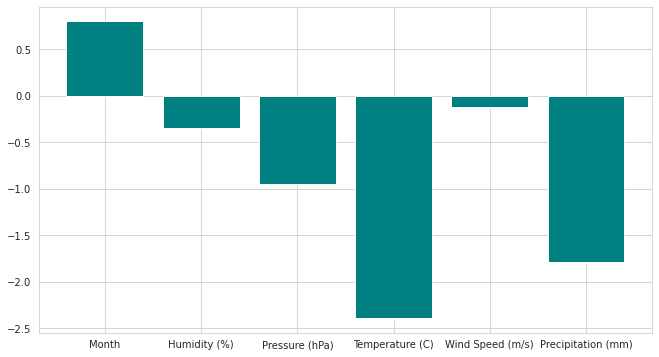

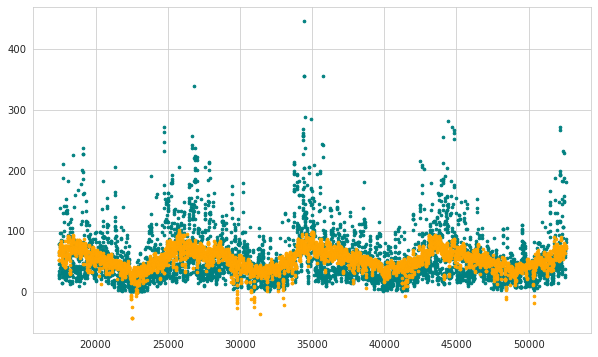

In [84]:
# Prvi model linearne regresije - standardna linearna regresija prvog stepena
# (prvog stepena je jer se fituje linearni model)

# Treniranje nad trening skupom, predikcija nad validacionim skupom, (pa za ridge) selektovanje najboljeg modela i pamcenje rezultata, 
# pa spajanje trening i validacionog skupa i ponovno treniranje nad njima, i predikcija nad test skupom i pamcenje rezultata




# izbacivanje obelezja (selekcija obelezja) moze za svaki tip regresije
# unazad je sa svim, pa izbacivanje obelezja
# moze ovo da se radi, i moze menjanje parametara (kod lasso i ridge, za obicnu nema smisla)

# linearna obicna full
# linearna sa izbacenim obelezjima
# ridge sa izbacenim obelezjima
# za ridge za parametre mogu da iteriram kroz listu za solver

# --------------------

# Treniranje nad trening skupom i predikcija nad validacionim skupom

model = LinearRegression(fit_intercept=True)
model.fit(x_train, y_train)

y_predicted = model.predict(x_valid)
linRegResults = model_evaluation(y_valid, y_predicted, x_train.shape[0], x_train.shape[1], silent=True)
print()
plt.figure(figsize=(11,6))
sb.set_style("whitegrid")
plt.bar(x.columns, model.coef_, color = "teal")
plt.savefig("coeffsSimpleValid.png")
print("Koeficijenti :", model.coef_)

plt.figure(figsize=(10,6))
plt.scatter(x_valid.index, y_valid, s=7, c="teal")
plt.scatter(x_valid.index, y_predicted, s=7, c="orange")
plt.savefig("scatterSimpleValid.png")

/home/stankovictab/.local/lib/python3.10/site-packages/sklearn/base.py:402: UserWarning: X has feature names, but LinearRegression was fitted without feature names
  warnings.warn(


Mean squared error:  1395.4816136690056
Mean absolute error:  26.410295972744624
Root mean squared error:  37.35614559438655
R2 score:  0.18113090023021017
R2 adjusted score:  0.18096637507873103
      y     y_pred
0  23.0  41.973167
1  10.0  52.156909
2  41.0  55.924490
3  58.0  54.312621
4  39.0  45.720494

Koeficijenti : [ 0.83504831 -0.34675266 -0.96425694 -2.41377846 -0.11901058 -1.85810703]


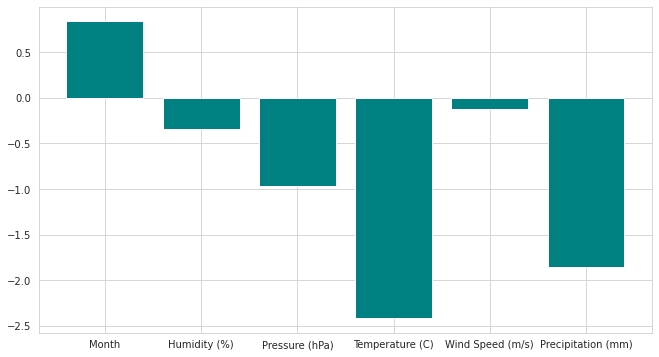

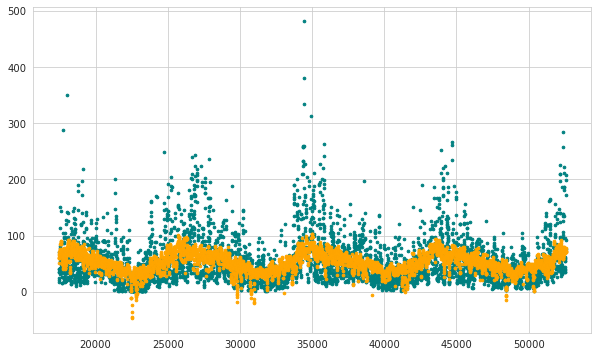

In [85]:
# Pravimo novi skup za treniranje na osnovu trening skupa i skupa za validaciju

x_inter_combined = np.concatenate((x_train, x_valid), axis=0)
y_combined = np.concatenate((y_train, y_valid), axis=0)

# Treniranje nad kombinovanim skupom
model.fit(x_inter_combined, y_combined)

# Predikcija nad test skupom
y_predicted = model.predict(x_test)
linRegResults = model_evaluation(y_test, y_predicted, x_inter_combined.shape[0], x_inter_combined.shape[1], silent=False)
print()
plt.figure(figsize=(11,6))
sb.set_style("whitegrid")
plt.bar(x.columns, model.coef_, color = "teal")
plt.savefig("coeffsSimpleTest.png")
print("Koeficijenti :", model.coef_)

plt.figure(figsize=(10,6))
plt.scatter(x_test.index, y_test, s=7, c="teal")
plt.scatter(x_test.index, y_predicted, s=7, c="orange")
plt.savefig("scatterSimpleTest.png")

Rezultati Standardne linearne regresije nakon predikcije nad test skupom, koristeci sva obelezja, su sledeci :\
Mean squared error:  1395.4816136690056\
Mean absolute error:  26.410295972744624\
Root mean squared error:  37.35614559438655\
R2 score:  0.18113090023021017\
R2 adjusted score:  0.18096637507873103

Rezultati Standardne linearne regresije nakon predikcije nad test skupom, bez koriscenja obelezja Humidity i Temperature, su sledeci :\
Mean squared error:  1597.8396222549086\
Mean absolute error:  28.083457178067174\
Root mean squared error:  39.97298615633949\
R2 score:  0.06238714990140837\
R2 adjusted score:  0.062261569744020306

In [86]:
# Ridge model linearne regresije

# Standardizacija vrednosti obelezja

scaler = StandardScaler()
scaler.fit(x_train)
x_train_std = scaler.transform(x_train)
x_valid_std = scaler.transform(x_valid)
x_train_std = pd.DataFrame(x_train_std)
x_valid_std = pd.DataFrame(x_valid_std)
x_train_std.columns = list(x.columns)
x_valid_std.columns = list(x.columns)

poly = PolynomialFeatures(degree=2, interaction_only=False, include_bias=False)
# Sa interaction_only = False ubacamo i kvadratne parametre u funkciju
x_inter_train = poly.fit_transform(x_train_std)
x_inter_valid = poly.transform(x_valid_std)

# Lista parametara koji se testiraju
alphaList = [0.1, 0.5, 1, 1.5, 3, 5]
solverList = ["svd", "cholesky", "saga"]
max_iterList = [100, 500, 1000]

ridgeResultsMatrix = []

for alpha in alphaList:
	for solver in solverList:
		for max_iter in max_iterList:
			ridge_model = Ridge(alpha=alpha, solver=solver, max_iter=max_iter)
			ridge_model.fit(x_inter_train, y_train) # Trenira se uvek nad trening skupu sa razlicitim parametrima
			y_predicted = ridge_model.predict(x_inter_valid) # Predikcija se vrsi nad validacionim skupom
			ridgeResultsMatrix.append(list(model_evaluation(y_valid, y_predicted, x_inter_train.shape[0], x_inter_train.shape[1], silent=True)))
			# print("Alpha: ", alpha, "Solver: ", solver, "Max iter: ", max_iter)
			# print("Koeficijenti :", ridge_model.coef_)

/home/stankovictab/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/stankovictab/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/stankovictab/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/stankovictab/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/stankovictab/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/stankovictab/.local/lib/python3.10/site-pack

In [87]:
# Rezultati poredjenja modela Ridge regresije sa razlicitim paramterima
# Od ovih modela se bira onaj sa najbolji rezultatima (gde je najveci R2)

r2min = -999
for i in range(len(ridgeResultsMatrix)):
	print("Alpha: ", alphaList[i//9], "Solver: ", solverList[(i%9)//3], "Max iter: ", max_iterList[i%3])
	print(ridgeResultsMatrix[i])
	if ridgeResultsMatrix[i][3] > r2min:
		r2min = ridgeResultsMatrix[i][3]
		bestRidge = i

bestAlpha = alphaList[bestRidge//9] # 9 redova u results matrici, celobrojnim deljenjem sa 9 dobijamo indeks alfe
bestSolver = solverList[(bestRidge%9)//3] # Onda ostatak, pa celobrojno deljenje sa 3, jer se ponavljaju po 3 solvera
bestMaxIter = max_iterList[bestRidge%3] # Samo ostatak, najcesce se menja

print("\nBest alpha: ", bestAlpha, "\nBest solver: ", bestSolver, "\nBest max iter: ", bestMaxIter)
print("Best ridge results: ", ridgeResultsMatrix[bestRidge])

Alpha:  0.1 Solver:  svd Max iter:  100
[2116.020018738593, 33.4930944142042, 46.000217594470065, -0.24168128828554747, -0.2430457176853973]
Alpha:  0.1 Solver:  svd Max iter:  500
[2116.020018738593, 33.4930944142042, 46.000217594470065, -0.24168128828554747, -0.2430457176853973]
Alpha:  0.1 Solver:  svd Max iter:  1000
[2116.020018738593, 33.4930944142042, 46.000217594470065, -0.24168128828554747, -0.2430457176853973]
Alpha:  0.1 Solver:  cholesky Max iter:  100
[2116.0200187385935, 33.49309441420421, 46.000217594470065, -0.2416812882855477, -0.2430457176853975]
Alpha:  0.1 Solver:  cholesky Max iter:  500
[2116.0200187385935, 33.49309441420421, 46.000217594470065, -0.2416812882855477, -0.2430457176853975]
Alpha:  0.1 Solver:  cholesky Max iter:  1000
[2116.0200187385935, 33.49309441420421, 46.000217594470065, -0.2416812882855477, -0.2430457176853975]
Alpha:  0.1 Solver:  saga Max iter:  100
[1727.1365765723133, 29.73614676844752, 41.558832714265606, -0.013484348187696282, -0.0145980

In [88]:
# Pravimo novi skup za treniranje na osnovu trening skupa i skupa za validaciju

x_inter_combined = np.concatenate((x_train, x_valid), axis=0)
y_combined = np.concatenate((y_train, y_valid), axis=0)

/home/stankovictab/.local/lib/python3.10/site-packages/sklearn/base.py:402: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


(29870, 6)
(5271, 6)


/home/stankovictab/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Mean squared error:  1540.0358919142382
Mean absolute error:  27.832385808203462
Root mean squared error:  39.24329104336483
R2 score:  0.09630639911526995
R2 adjusted score:  0.0954887686875544
      y     y_pred
0  23.0  48.791588
1  10.0  47.029570
2  41.0  53.911147
3  58.0  52.887873
4  39.0  55.532742
Koeficijenti : [-0.32765474 -0.47822129  1.31993128 -1.69909985 -0.84583522 -0.28603898
  1.79095524 -0.13777373  0.42646011 -0.54398108  0.19743813  0.01360446
  0.1119209   0.36012602 -0.20118285 -0.12120457 -0.32682304 -0.12471584
 -0.08207157 -0.13425154  0.00415528  0.16368195  0.22209391  0.18984407
 -1.05665024 -0.01131225 -0.01828151]


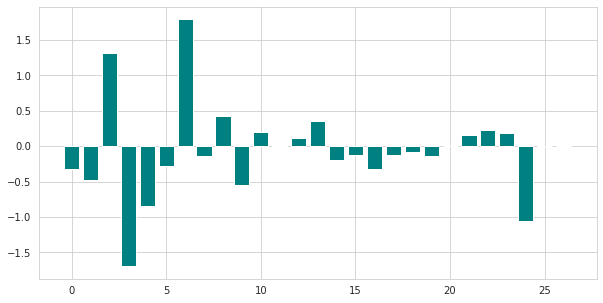

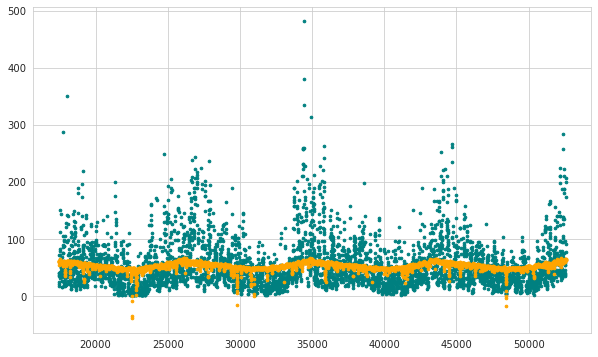

In [89]:
# Treniranje najboljeg Ridge modela nad trening + validacionim skupom
# Nakon toga se plotuje u poredjenju sa test skupom

print(x_inter_combined.shape)
print(x_test.shape)

scaler = StandardScaler()
scaler.fit(x_inter_combined) # Mora da prima 6 kolona da bi prebacio u 27
x_inter_combined_std = scaler.transform(x_inter_combined)
x_test_std = scaler.transform(x_test)
x_inter_combined_std = pd.DataFrame(x_inter_combined_std)
x_test_std = pd.DataFrame(x_test_std)
x_inter_combined_std.columns = list(x.columns)
x_test_std.columns = list(x.columns)

poly = PolynomialFeatures(degree=2, interaction_only=False, include_bias=False)
# Sa interaction_only = False ubacamo i kvadratne parametre u funkciju
x_inter_train = poly.fit_transform(x_inter_combined_std)
x_inter_test = poly.transform(x_test_std)

ridge_model = Ridge(alpha=bestAlpha, solver=bestSolver, max_iter=bestMaxIter)
ridge_model.fit(x_inter_train, y_combined) # Kreiranje modela na osnovu prosirenog skupa za treniranje
y_predicted = ridge_model.predict(x_inter_test) # Predikcija nad test skupom
model_evaluation(y_test, y_predicted, x_inter_train.shape[0], x_inter_train.shape[1], silent=False) # Rezultat na osnovu test skupa
plt.figure(figsize=(10,5))
sb.set_style("whitegrid")
plt.bar(range(len(ridge_model.coef_)),ridge_model.coef_, color="teal")
plt.savefig("coeffsRidge.png")
print("Koeficijenti :", ridge_model.coef_)

plt.figure(figsize=(10,6))
plt.scatter(x_test.index, y_test, s=7, c="teal")
plt.scatter(x_test.index, y_predicted, s=7, c="orange")
plt.savefig("scatterRidge.png") 

Rezultati Ridge regresije nakon predikcije nad test skupom, koristeci sva obelezja, su sledeci :\
Mean squared error:  1539.9566275238803\
Mean absolute error:  27.8318311148103\
Root mean squared error:  39.242281120290144\
R2 score:  0.09635291148729996\
R2 adjusted score:  0.09553532314235513

Rezultati Ridge regresije nakon predikcije nad test skupom, bez koriscenja obelezja Humidity i Temperature, su sledeci :\
Mean squared error:  1606.4064833002287\
Mean absolute error:  28.45021287824813\
Root mean squared error:  40.0800010391745\
R2 score:  0.05736011283884901\
R2 adjusted score:  0.056918077721774596

## kNN Klasifikator

In [108]:
# Kreiranje nove kolone
result = []
for i, row in df.iterrows():
	if row.loc["PM (ug/m3)"] <= 55.4:
		result.append("Safe")
	elif row.loc["PM (ug/m3)"] <= 150.4:
		result.append("Unsafe")
	else:
		result.append("Dangerous")
df["Toxicity"] = result
print(df.tail())

       Year  Month  Day  Hour  Season  PM (ug/m3)  Dew Temp (C)  Humidity (%)  \
52579  2015     12   31    19       4        82.0          -1.0         65.13   
52580  2015     12   31    20       4        93.0           1.0         70.27   
52581  2015     12   31    21       4        90.0           1.0         70.27   
52582  2015     12   31    22       4        86.0           0.0         70.06   
52583  2015     12   31    23       4        77.0           0.0         70.06   

       Pressure (hPa)  Temperature (C) Wind Direction  Wind Speed (m/s)  \
52579          1035.0              5.0              2              15.0   
52580          1035.0              6.0              2              19.0   
52581          1036.0              6.0              2              22.0   
52582          1035.0              5.0              2              25.0   
52583          1035.0              5.0              2              27.0   

       Precipitation (mm)  TotalPrec (mm) Toxicity  
52579    

In [ ]:
# Deljenje celokupne baze na trening i test skup

x = df.drop(["Toxicity"], axis=1)
y = df["Toxicity"]

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.15, random_state=42)

In [116]:
metrics = ["minkowski", "dice"] # Metricke funkcije za izracunavanje razdaljine izmedju tacaka u prostoru

for n in range(1, 5):
	print("Obradjuju se", n+1, "komsije.")
	for metric in metrics:
		skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
		indexes = skf.split(x_train, y_train)
		# Matrica konfuzije je puna nula, pa se inkrementuje
		confusionMatrix = np.zeros((len(np.unique(y_train)), len(np.unique(y_train))))
		for train_index, test_index in indexes:
			x_train_fold, x_test_fold = x_train.iloc[train_index, :].values, x_train.iloc[test_index, :].values
			y_train_fold, y_test_fold = y_train.iloc[train_index], y_train.iloc[test_index]
			knn = KNeighborsClassifier(n_neighbors=n+1, metric=metric) # TODO: n ili n+1?
			knn.fit(x_train_fold, y_train_fold) # Obuka klasifikatora
			y_predicted = knn.predict(x_test_fold)

			# TODO: dimenzije nisu iste?
			print(y_test_fold.shape, y_predicted.shape)
			print(confusionMatrix.shape)
			print(confusion_matrix(y_test_fold, y_predicted).shape)
			confusionMatrix += confusion_matrix(y_test_fold, y_predicted)

			print("Tacnost: ", accuracy_score(y_train.iloc[test_index], y_predicted))
		# Suma na glavnoj dijagonali / suma svih elemenata matrice
		print('Tacno Predvidjeni (%): ', sum(np.diag(confusionMatrix))/sum(sum(confusionMatrix)))

		# Prikaz matrice konfuzije
		disp = ConfusionMatrixDisplay(confusion_matrix = confusionMatrix, display_labels = knn.classes_)
		# cm = confusion_matrix(np.arange(25), np.arange(25))
		# fig, ax = plt.subplots(figsize = (10, 10))
		# disp.plot(ax=ax, cmap="Blues", values_format='')
		# plt.show()

Obradjuju se 2 komsije.


/home/stankovictab/.local/lib/python3.10/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(


(2460,) (2460,)
(315, 315)
(226, 226)


ValueError: operands could not be broadcast together with shapes (315,315) (226,226) (315,315) 

In [ ]:
# TODO: Mere uspesnosti